In [19]:
import pandas as pd
import numpy as np

#data preprocessing
from scipy.stats import kurtosis
from scipy.stats import skew
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

#coefficient generator
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

#cluster model
from sklearn_extra.cluster import KMedoids

#xgboost and LR
import xgboost as xgb
from sklearn.metrics import roc_curve, auc

#dimension reduction
from sklearn.decomposition import PCA

#graph
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [48]:
gmc = pd.read_csv("C:\\Users\\king0\\OneDrive\\鄧惠文專題\\GMC\\gmc-training.csv").drop(columns='Unnamed: 0')

In [49]:
#check missing value
gmc.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [50]:
y = gmc['SeriousDlqin2yrs'].rename('y')
X = gmc.drop(columns='SeriousDlqin2yrs').rename(columns={'RevolvingUtilizationOfUnsecuredLines': 'x1', 
                                                         'age': 'x2',
                                                         'NumberOfTime30-59DaysPastDueNotWorse': 'x3',
                                                         'DebtRatio' : 'x4',
                                                         'MonthlyIncome': 'x5',
                                                         'NumberOfOpenCreditLinesAndLoans': 'x7',
                                                         'NumberOfTimes90DaysLate': 'x8',                                            
                                                         'NumberRealEstateLoansOrLines': 'x9',
                                                         'NumberOfTime60-89DaysPastDueNotWorse': 'x10',
                                                         'NumberOfDependents': 'x11',
                                                         })

step1-1 : Log transformation 

In [51]:
for col in X.columns :
    origin_mean = X[col].describe()['mean']
    min_number = 10**(int(str("%e"%origin_mean)[-3:])-6)
    data = X[col] + min_number
    if  np.isnan(kurtosis(data)) :
        data = data.dropna()
    if kurtosis(data) > 10 :
        X[col] = pd.DataFrame(np.log(data))

step1-2: Z-scaling

In [52]:
scalor = StandardScaler()
for col in X.columns :
    X[col] = scalor.fit_transform(pd.DataFrame(X[col]))

step1-3: fill missing value

In [53]:
X['x6'] = X['x5'].isnull()*1
X['x12'] = X['x11'].isnull()*1
X = X.fillna(0)
order = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12']
X = X.reindex(columns=order)

In [54]:
# show table
summary_stat = np.round(X.describe(), 1)
summary_stat.loc['skewness'] = np.round(skew(X), 1)
summary_stat.loc['kurtosis'] = np.round(kurtosis(X), 1)
summary_stat = summary_stat.drop(['25%', 'count', '75%'])

temp = np.round(y.describe().drop(['25%', 'count', '75%']), 1)
temp['skewness'] = np.round(skew(y), 1)
temp['kurtosis'] = np.round(kurtosis(y), 1)
summary_stat['y'] = temp

order = ['y','x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12']
summary_stat.reindex(columns=order).T
#until this step, everything fits on paper 

,mean,std,min,50%,max,skewness,kurtosis
y,0.1,0.2,0.0,0.0,1.0,3.5,10.0
x1,0.0,1.0,-3.1,0.3,3.9,-2.1,4.2
x2,0.0,1.0,-3.5,-0.0,3.8,0.2,-0.5
x3,-0.0,1.0,-0.4,-0.4,3.0,1.9,1.5
x4,-0.0,1.0,-2.4,-0.2,3.3,0.7,0.6
x5,-0.0,0.9,-7.6,0.0,3.3,-6.9,54.4
x6,0.2,0.4,0.0,0.0,1.0,1.5,0.3
x7,0.0,1.0,-1.6,-0.1,9.6,1.2,3.1
x8,-0.0,1.0,-0.2,-0.2,5.2,3.9,13.3
x9,0.0,1.0,-1.3,0.7,1.3,-0.5,-1.7


step2 : dimension transformation 

In [55]:
#do this in step4 rescalor class

step3 : data split 

In [56]:
#80%-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

step4 : rescalor

In [57]:
class rescalor :
    def __init__(self, power, X_train, X_test, y_train) :
        poly_model = PolynomialFeatures(power, include_bias=False)
        original_train = X_train.drop(columns=['x6', 'x12']) 
        original_test = X_test.drop(columns=['x6', 'x12'])
        self.X_train = pd.DataFrame(np.append(poly_model.fit_transform(original_train), X_train[['x6', 'x12']], axis=1))
        self.X_test = pd.DataFrame(np.append(poly_model.fit_transform(original_test), X_test[['x6', 'x12']], axis=1))
        self.y_train = y_train
        self.reg_w = []
        self.lr_w = []
        self.mi_w = []
        #record weight of each rescalor
    
    def rescaling(self) :
        #fitting function
        reg = LinearRegression()
        lr = LogisticRegression()
        reg.fit(self.X_train, self.y_train)
        lr.fit(self.X_train, self.y_train)
        self.mi_w = mutual_info_classif(self.X_train, self.y_train)
        self.reg_w = reg.coef_
        self.lr_w = lr.coef_[0]        
        

    #fuck this function doesn't change test data's dimension
    def get_data(self, test=False) :
        if test :
            orig_data = self.X_test
            reg_data = self.X_test*pd.Series(self.reg_w)
            lr_data = self.X_test*pd.Series(self.lr_w)
            mi_data = self.X_test*pd.Series(self.mi_w)
        else : 
            orig_data = self.X_train
            reg_data = self.X_train*pd.Series(self.reg_w)
            lr_data = self.X_train*pd.Series(self.lr_w)
            mi_data = self.X_train*pd.Series(self.mi_w) 
               
        return orig_data, reg_data, lr_data, mi_data 


step5 : clustering、step6 : sub modeling

In [58]:
#This class deals with all process in step5, including default ratio and entropy. 
class cluster_prediction :
    def __init__(self, X_train, X_test, y_train, y_test, K) : #parameter y is literal y(not y_train or y_test)
        self.X_train = X_train.reset_index(drop=True)
        self.X_test = X_test.reset_index(drop=True)
        self.y_train = y_train.reset_index(drop=True)
        self.y_test = y_test.reset_index(drop=True)
        self.K = K

        #record the ratio for each group in all data
        self.cluster_prop_train = []  
        self.cluster_prop_test = []     

    def cluster_model (self, positive=False) :
        kmedoids = KMedoids(n_clusters=self.K)
        if positive :
            table = self.X_train.join(self.y_train)
            pos_table = table[table['y'] == 1].drop(columns=['y'])
            kmedoids.fit(pos_table)#model pos-case data
            self.clustermodel = kmedoids
        else :
            kmedoids.fit(self.X_train)#model all-case data
            self.clustermodel = kmedoids
    
    def cluster_predict(self, test=False) :
        if test :
            table = self.X_test.join(self.y_test)
            table['cluster'] = self.clustermodel.predict(self.X_test)
            self.cluster_X_test = table.drop(columns=['y'])
            return table
        else :
            table = self.X_train.join(self.y_train)
            table['cluster'] = self.clustermodel.predict(self.X_train) 
            self.cluster_X_train = table.drop(columns=['y'])
            return table
            #X_train with cluster label

    def default_ratio(self, test=False) : 
        ratio = []
        if test :
            table = self.cluster_predict(test=True)
            for cluster in range(0, self.K) : 
                temp = table[table['cluster']==cluster]
                self.cluster_prop_test.append(len(temp)/len(self.X_test)) #group's proportion in all data
                ratio.append(sum(temp['y'])/len(temp)) #group's default ratio
            self.ratio_test = ratio
        else :    
            table = self.cluster_predict()
            for cluster in range(0, self.K) : 
                temp = table[table['cluster']==cluster]
                self.cluster_prop_train.append(len(temp)/len(self.X_train)) 
                ratio.append(sum(temp['y'])/len(temp)) 
            self.ratio_train = ratio
        return ratio

    def submodel_auc(self, test=False) :
        lr_proba = []
        xgb_proba = []
        label_y = []
        train_all_table = self.cluster_X_train.join(self.y_train)
        test_all_table  = self.cluster_X_test.join(self.y_test)
        #因為要知道對應的y是多少，所以使用all_table
        for cluster in range(0, self.K) :
            train_table = train_all_table[train_all_table['cluster']==cluster] 
            test_table =  test_all_table[test_all_table['cluster']==cluster] 
            lrmodel = LogisticRegression().fit(train_table.drop(columns=['y', 'cluster']), train_table['y'])
            xgbmodel = xgb.XGBClassifier().fit(train_table.drop(columns=['y', 'cluster']), train_table['y'])
            if test :
                lr_proba = np.concatenate((lrmodel.predict_proba(test_table.drop(columns=['y', 'cluster']))[:,1], lr_proba))
                xgb_proba = np.concatenate((xgbmodel.predict_proba(test_table.drop(columns=['y', 'cluster']))[:,1], xgb_proba))
                label_y = np.concatenate((test_table['y'], label_y))
            else :
                lr_proba = np.concatenate((lrmodel.predict_proba(train_table.drop(columns=['y', 'cluster']))[:,1], lr_proba))
                xgb_proba = np.concatenate((xgbmodel.predict_proba(train_table.drop(columns=['y', 'cluster']))[:,1], xgb_proba))
                label_y = np.concatenate((train_table['y'], label_y))

            fpr, tpr, threshold = roc_curve(label_y, lr_proba)
            lr_auc = auc(fpr, tpr)
            fpr, tpr, threshold = roc_curve(label_y, xgb_proba)
            xgb_auc = auc(fpr, tpr)
        return  [lr_auc, xgb_auc]
            

    def entropy(self, test=False) : #give it a 'test' parameter 
        h_mean = 0
        if test :
            for p, q in zip(self.ratio_test, self.cluster_prop_test) :
                if p == 0 or p==1:
                    h = 0
                else :
                    h = -(p*math.log2(p) + (1-p)*math.log2(1-p))
                h_mean += q*h
            return h_mean
        
        for p, q in zip(self.ratio_train, self.cluster_prop_train) :
            if p == 0 or p==1:
                h = 0
            else :
                h = -(p*math.log2(p) + (1-p)*math.log2(1-p))
            h_mean += q*h
        return h_mean         

In [77]:
# default rate data 
upper = 40000
rescalor_data = rescalor(1, X_train[:upper], X_test, y_train[:upper])
rescalor_data.rescaling()
reg_w_1, lr_w_1, mi_w_1 = rescalor_data.reg_w, rescalor_data.lr_w, rescalor_data.mi_w
orig_train_1, reg_train_1, lr_train_1, mi_train_1 = rescalor_data.get_data()
orig_test_1, reg_test_1, lr_test_1, mi_test_1 = rescalor_data.get_data(test=True)

rescalor_data = rescalor(2, X_train[:upper], X_test, y_train[:upper])
rescalor_data.rescaling()
reg_w_2, lr_w_2, mi_w_2 = rescalor_data.reg_w, rescalor_data.lr_w, rescalor_data.mi_w
orig_train_2, reg_train_2, lr_train_2, mi_train_2 = rescalor_data.get_data()
orig_test_2, reg_test_2, lr_test_2, mi_test_2 = rescalor_data.get_data(test=True)

rescalor_data = rescalor(3, X_train[:upper], X_test, y_train[:upper])
rescalor_data.rescaling()
reg_w_3, lr_w_3, mi_w_3 = rescalor_data.reg_w, rescalor_data.lr_w, rescalor_data.mi_w
orig_train_3, reg_train_3, lr_train_3, mi_train_3 = rescalor_data.get_data()
orig_test_3, reg_test_3, lr_test_3, mi_test_3 = rescalor_data.get_data(test=True)

In [80]:
#check consistency of the coefficient table
ew_w_1 = np.ones(len(reg_w_1))
weight_1 = [ew_w_1, reg_w_1, lr_w_1, mi_w_1]
ew_w_2 = np.ones(len(reg_w_2))
weight_2 = [ew_w_2, reg_w_2, lr_w_2, mi_w_2]
ew_w_3 = np.ones(len(reg_w_3))
weight_3 = [ew_w_3, reg_w_3, lr_w_3, mi_w_3]


print('origin data')
print(np.round(pd.DataFrame(np.percentile(weight_1, [0, 10, 25, 50, 75, 90, 100], axis=1))\
.rename(columns={0:'EW', 1:'REG', 2:'LR', 3:'MI'}, 
        index={0:'min', 1:'10%', 2:'25%', 3:'median', 4:'75%', 5:'90%', 6:'max'}).T, 2))

print('quadratic data')
print(np.round(pd.DataFrame(np.percentile(weight_2, [0, 10, 25, 50, 75, 90, 100], axis=1))\
.rename(columns={0:'EW', 1:'REG', 2:'LR', 3:'MI'}, 
        index={0:'min', 1:'10%', 2:'25%', 3:'median', 4:'75%', 5:'90%', 6:'max'}).T, 2))

print('cubic data')
print(np.round(pd.DataFrame(np.percentile(weight_3, [0, 10, 25, 50, 75, 90, 100], axis=1))\
.rename(columns={0:'EW', 1:'REG', 2:'LR', 3:'MI'}, 
        index={0:'min', 1:'10%', 2:'25%', 3:'median', 4:'75%', 5:'90%', 6:'max'}).T, 2))

origin data
      min   10%   25%  median   75%   90%   max
EW   1.00  1.00  1.00    1.00  1.00  1.00  1.00
REG -0.02 -0.01 -0.00    0.00  0.02  0.04  0.06
LR  -0.58 -0.28 -0.16    0.07  0.28  0.41  0.64
MI   0.00  0.00  0.00    0.01  0.03  0.03  0.04
quadratic data
      min   10%   25%  median   75%   90%   max
EW   1.00  1.00  1.00    1.00  1.00  1.00  1.00
REG -0.26 -0.01 -0.00    0.00  0.00  0.01  0.31
LR  -0.86 -0.09 -0.04   -0.01  0.04  0.11  0.91
MI   0.00  0.00  0.00    0.02  0.03  0.04  0.05
cubic data
      min   10%   25%  median   75%   90%   max
EW   1.00  1.00  1.00    1.00  1.00  1.00  1.00
REG -3.28 -0.02 -0.00   -0.00  0.00  0.02  1.57
LR  -1.04 -0.09 -0.04    0.00  0.02  0.09  0.47
MI   0.00  0.00  0.01    0.02  0.03  0.04  0.06


In [81]:
dataset_train = [orig_train_1, reg_train_1, lr_train_1, mi_train_1, 
                 orig_train_2, reg_train_2, lr_train_2, mi_train_2,
                 orig_train_3, reg_train_3, lr_train_3, mi_train_3]

dataset_test = [orig_test_1, reg_test_1, lr_test_1, mi_test_1,
                orig_test_2, reg_test_2, lr_test_2, mi_test_2,
                orig_test_3, reg_test_3, lr_test_3, mi_test_3] 

ratio_train, ratio_test, entropy_train, entropy_test, auc_train, auc_test = [], [], [], [], [], []  
for train_data, test_data in zip(dataset_train, dataset_test):# <-different rescaled data
    ratio_set_train, entropy_set_train, ratio_set_test,  entropy_set_test, auc_set_train, auc_set_test= [], [], [], [], [], []
    #auc_set_train = [] <- [[lr, xgb](k=2), [lr, xgb](k=3)]
    
    for K in range(1, 10) :
        C = cluster_prediction(train_data[:600], test_data[:600], y_train[:600], y_test[:600], K)
        C.cluster_model()
        ratio_tr = C.default_ratio()
        ratio_te = C.default_ratio(test=True)
        if K > 1 :
            ratio_set_train.append(ratio_tr)
            entropy_set_train.append(C.entropy())
            ratio_set_test.append(ratio_te)
            entropy_set_test.append(C.entropy(test=True))
        if K <= 4:
            auc_set_train.append(C.submodel_auc())
            auc_set_test.append(C.submodel_auc(test=True))

    ratio_train.append(ratio_set_train)            # [[EW_ratio_1], [REG_ratio_1], [LR_ratio_1], [MI_ratio_1], [EW_ratio_2], [REG_ratio_2], [LR_ratio_2], [MI_ratio_2],...]   
                                                   # in [EW_ratio_1] -> [[0.06], [0.02, 0.14], [0.012, 0.07, 0.03], [0.018, 0.019, 0.1, 0.12],...]      
    entropy_train.append(entropy_set_train) 
    ratio_test.append(ratio_set_test)
    entropy_test.append(entropy_set_test)
    auc_train.append(auc_set_train)                
    # [[[EW_K=1_D=1], [EW_K=2_D=1], [EW_K=3_D=1]],
    #  [[REG_K=1_D=1],[REG_K=2_D=1],[REG_K=3_D=1]],
    #  [[LR_K=1]_D=1,[LR_K=2_D=1],[LR_K=3_D=1]], 
    #  [[MI_K=1_D=1],[MI_K=2_D=1],[MI_K=3_D=1]],
    #  [[EW_K=1_D=2], [EW_K=2_D=2], [EW_K=3_D=2]], ...]
    auc_test.append(auc_set_test)
    #auc: 1.指定要哪一種scalored data以及什麼維度 2. 要K為多少的 3.得到[lr, xgb]


ratio_trainp, ratio_testp, entropy_trainp, entropy_testp, auc_trainp, auc_testp = [], [], [], [], [], [] 
for train_data, test_data in zip(dataset_train, dataset_test):
    ratio_set_train, entropy_set_train, ratio_set_test,  entropy_set_test, auc_set_train, auc_set_test= [], [], [], [], [], []    
    for K in range(1, 10) :
        Cp = cluster_prediction(train_data[:600], test_data[:600], y_train[:600], y_test[:600], K)
        Cp.cluster_model(positive=True)
        ratio_tr = Cp.default_ratio()
        ratio_te = Cp.default_ratio(test=True)
        if K > 1 :
            ratio_set_train.append(ratio_tr)
            entropy_set_train.append(Cp.entropy())
            ratio_set_test.append(ratio_te)
            entropy_set_test.append(Cp.entropy(test=True))
        if K <= 4:
            auc_set_train.append(Cp.submodel_auc())
            auc_set_test.append(Cp.submodel_auc(test=True))

    ratio_trainp.append(ratio_set_train)                 
    entropy_trainp.append(entropy_set_train) 
    ratio_testp.append(ratio_set_test)
    entropy_testp.append(entropy_set_test)
    auc_trainp.append(auc_set_train)                
    auc_testp.append(auc_set_test)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [72]:
#graph function 
def default_rate(alldata) : #all includes four type of rescaling data
    fig = make_subplots(rows=2, 
                        cols=4, 
                        shared_yaxes=True,
                        subplot_titles=('All, EW', 'All, REG', 'All, LR', 'ALL, MI',
                                        'POS, EW', 'POS, REG', 'POS, LR', 'POS, MI')) 
    row, col = 0, 0
    color = 'blue'
    name = 'train default rate'
    legend = True
    average_line = True
    for dataset in alldata : 
        # allEW(tr), allREG(tr), allLR(tr), allMI(tr), 
        # posEW(tr), posREG(tr), posLR(tr), posMI(tr),
        # allEW(te), allREG(te), allLR(te), allMI(te), 
        # posEW(te), posREG(te), posLR(te), posMI(te)
        if row > 7 :
            color = 'red'
            name = 'test default rate'
            legend = True
            average_line = False
        row, col = row%8, col%8                     
        coordinate_x, coordinate_y = [], []
        for data, x in zip(dataset, range(2, 10)) : #different Ks
            for rate in data :  #different groups
                coordinate_x.append(x)
                coordinate_y.append(rate) 
        fig.append_trace(go.Scatter(x = coordinate_x, 
                                    y = coordinate_y, 
                                    mode='markers',
                                    marker=dict(color=color),
                                    name=name,
                                    showlegend=legend),
                                    row=(row//4)+1, col=(col%4)+1)  
        if average_line :
            fig.append_trace(go.Scatter(x = [1, 10],
                                        y = [0.067, 0.067],
                                        mode='lines',
                                        marker=dict(color='black'),
                                        name='all data default rate',
                                        showlegend=legend),
                                        row=(row//4)+1, col=(col%4)+1)         
        col += 1
        row += 1 
        legend = False
    fig.update_layout(xaxis1=dict(dtick=1), xaxis2=dict(dtick=1), 
                      xaxis3=dict(dtick=1), xaxis4=dict(dtick=1),
                      xaxis5=dict(dtick=1), xaxis6=dict(dtick=1), 
                      xaxis7=dict(dtick=1), xaxis8=dict(dtick=1),
                      xaxis1_title_text="K",xaxis2_title_text="K",
                      xaxis3_title_text="K",xaxis4_title_text="K",
                      xaxis5_title_text="K",xaxis6_title_text="K",
                      xaxis7_title_text="K",xaxis8_title_text="K",
                      yaxis1_title_text="default rate", yaxis5_title_text="default rate")
    
    fig.update(layout_yaxis1_range = [0, 0.6],
               layout_yaxis5_range = [0, 0.6],
               layout_xaxis1_range = [1.5, 9.5],
               layout_xaxis2_range = [1.5, 9.5],
               layout_xaxis3_range = [1.5, 9.5],
               layout_xaxis4_range = [1.5, 9.5],
               layout_xaxis5_range = [1.5, 9.5],
               layout_xaxis6_range = [1.5, 9.5],
               layout_xaxis7_range = [1.5, 9.5],
               layout_xaxis8_range = [1.5, 9.5])

    fig.update_layout(height=800, width=800)
    # fig.write_html("default_rate.html")
    fig.show()


def entropy_trend(alldata) :
    #[[ALL, original], [ALL, quadratic], [ALL, cubic], [POS, original], [POS, quadratic], [POS, cubic]]
    #in [ALL, original], [[train_EW], [train_REG], [train_LR], [train_MI], [test_EW], [test_REG], [test_LR], [test_MI]]                                                        
    row = 0
    col = 0
    legend = True
    name = ['EW, train', 'REG, train', 'LR, train', 'MI, train', 'EW, test', 'REG, test', 'LR, test', 'MI, test']
    color = ['blue', 'peru', 'red', 'green', 'blue', 'peru', 'red', 'green']
    fig = make_subplots(rows=3, 
                        cols=2, 
                        shared_yaxes=True,
                        subplot_titles=('All, original', 'POS, original', 'All, quadratic', 'POS, quadratic','All, cubic',  'POS, cubic'),
                        x_title='K',
                        y_title='Entropy')
    for graph in alldata : #origin(tr), quadratic(tr), cubic(tr), origin(te), quadratic(te), cubic(te),
        line = None
        index = 0
        for data in graph : #different data
            if index > 3 :
                line = "dot"
            fig.append_trace(go.Scatter(x = list(range(2, 10)), 
                                        y = data,
                                        name=name[index],
                                        line = dict(dash=line),
                                        marker=dict(color=color[index]),
                                        showlegend=legend),        
                                        row=(row%3)+1, col=(col//3)+1)   
            index += 1    
        fig.append_trace(go.Scatter(x = [2, 9], 
                                    y = [0.3546, 0.3546],
                                    name='K=1, train, test',
                                    marker=dict(color = 'black'),
                                    showlegend=legend),
                                    row=(row%3)+1, col=(col//3)+1) 
        row += 1
        col += 1
        legend = False

    fig.update(layout_yaxis_range = [0.27, 0.37],
               layout_yaxis3_range = [0.27, 0.37],
               layout_yaxis5_range = [0.27, 0.37],
               layout_xaxis1_range = [1.5, 9.5],
               layout_xaxis3_range = [1.5, 9.5],
               layout_xaxis5_range = [1.5, 9.5])
    
    fig.update_layout(xaxis=dict(dtick=1), 
                      xaxis2=dict(dtick=1),
                      xaxis3=dict(dtick=1),
                      xaxis4=dict(dtick=1),
                      xaxis5=dict(dtick=1),
                      xaxis6=dict(dtick=1),
                      yaxis1=dict(dtick=0.02), 
                      yaxis2=dict(dtick=0.02),
                      yaxis3=dict(dtick=0.02),
                      yaxis4=dict(dtick=0.02),
                      yaxis5=dict(dtick=0.02),
                      yaxis6=dict(dtick=0.02))
    
    fig.update_layout(height=800, width=950)
    # fig.write_html("entropy_trend.html")
    fig.show()    
    
def AUC_comparision(alldata) :  
    #[[[test(k=1)], [train(k=1)]], [[test(k=2)], [train(k=2)]], [[test(k=3)], [train(k=3)]]]
    #in [test(k=1)] -> [[LR,ALL,test], [XGB,ALL,test], [LR,POS,test], [XGB,POS,test]]
    #in [XGB,POS,test] -> [ew, reg, lr, mi] 
    fig = make_subplots(rows = 4,
                        cols = 1,
                        subplot_titles=('Original, k=1', 'Original, k=2', 'Original, k=3', 'Original, k=4'),
                        x_title='rescalor',
                        y_title='AUC')
    databases = ['EW', 'REG', 'LR', 'MI']
    row = 1
    legend = True
    for K in alldata :
        fig.append_trace(go.Bar(name='LR,ALL,overffiting', x=databases, y=K[1][0], offsetgroup=0, marker_color='black', showlegend=legend),row = row, col = 1)
        fig.append_trace(go.Bar(name='LR,POS,overffiting', x=databases, y=K[1][2], offsetgroup=1, marker_color='black', showlegend=legend),row = row, col = 1)
        fig.append_trace(go.Bar(name='XGB,ALL,overffiting', x=databases, y=K[1][1], offsetgroup=2, marker_color='black', showlegend=legend),row = row, col = 1)
        fig.append_trace(go.Bar(name='XGB,POS,overffiting', x=databases, y=K[1][3], offsetgroup=3, marker_color='black', showlegend=legend),row = row, col = 1)
        fig.append_trace(go.Bar(name='LR,ALL,test', x=databases, y=K[0][0], offsetgroup=0, marker_color='darkblue', showlegend=legend), row = row, col = 1)
        fig.append_trace(go.Bar(name='LR,POS,test', x=databases, y=K[0][2], offsetgroup=1, marker_color='skyblue', showlegend=legend), row = row, col = 1)
        fig.append_trace(go.Bar(name='XGB,ALL,test', x=databases, y=K[0][1], offsetgroup=2, marker_color='green', showlegend=legend), row = row, col = 1)
        fig.append_trace(go.Bar(name='XGB,POS,test', x=databases, y=K[0][3], offsetgroup=3, marker_color='lightgreen', showlegend=legend), row = row, col = 1) 
                        
        fig.update_layout(barmode='group')
        row += 1
        legend = False

    fig.update_layout(height=800, width=950)
    fig.update_layout(yaxis1=dict(dtick=0.2), 
                      yaxis2=dict(dtick=0.2),
                      yaxis3=dict(dtick=0.2),
                      yaxis4=dict(dtick=0.2))
    # fig.write_html("AUC.html")
    fig.show()

In [73]:
defaultrate_data = [ratio_train[0], ratio_train[1], ratio_train[2], ratio_train[3], 
                    ratio_trainp[0], ratio_trainp[1], ratio_trainp[2], ratio_trainp[3],
                    ratio_test[0], ratio_test[1], ratio_test[2], ratio_test[3], 
                    ratio_testp[0], ratio_testp[1], ratio_testp[2], ratio_testp[3]]

entropytrend_data = [[entropy_train[0], entropy_train[1], entropy_train[2], entropy_train[3],
                      entropy_test[0], entropy_test[1], entropy_test[2], entropy_test[3]],
                     [entropy_train[4], entropy_train[5], entropy_train[6], entropy_train[7],
                      entropy_test[4], entropy_test[5], entropy_test[6], entropy_test[7]],
                     [entropy_train[8], entropy_train[9], entropy_train[10], entropy_train[11],
                      entropy_test[8], entropy_test[9], entropy_test[10], entropy_test[11]],
                     [entropy_trainp[0], entropy_trainp[1], entropy_trainp[2], entropy_trainp[3],
                      entropy_testp[0], entropy_testp[1], entropy_testp[2], entropy_testp[3]],
                     [entropy_trainp[4], entropy_trainp[5], entropy_trainp[6], entropy_trainp[7],
                      entropy_testp[4], entropy_testp[5], entropy_testp[6], entropy_testp[7]],
                     [entropy_trainp[8], entropy_trainp[9], entropy_trainp[10], entropy_trainp[11],
                      entropy_testp[8], entropy_testp[9], entropy_testp[10], entropy_testp[11]]]

AUC_data = [[[[auc_test[0][0][0], auc_test[1][0][0], auc_test[2][0][0], auc_test[3][0][0]], 
              [auc_test[0][0][1], auc_test[1][0][1], auc_test[2][0][1], auc_test[3][0][1]], 
              [auc_testp[0][0][0], auc_testp[1][0][0], auc_testp[2][0][0], auc_testp[3][0][0]], 
              [auc_testp[0][0][1], auc_testp[1][0][1], auc_testp[2][0][1], auc_testp[3][0][1]]], 
             [[auc_train[0][0][0], auc_train[1][0][0], auc_train[2][0][0], auc_train[3][0][0]], 
              [auc_train[0][0][1], auc_train[1][0][1], auc_train[2][0][1], auc_train[3][0][1]], 
              [auc_trainp[0][0][0], auc_trainp[1][0][0], auc_trainp[2][0][0], auc_trainp[3][0][0]], 
              [auc_trainp[0][0][1], auc_trainp[1][0][1], auc_trainp[2][0][1], auc_trainp[3][0][1]]]], 
            [[[auc_test[0][1][0], auc_test[1][1][0], auc_test[2][1][0], auc_test[3][1][0]], 
              [auc_test[0][1][1], auc_test[1][1][1], auc_test[2][1][1], auc_test[3][1][1]], 
              [auc_testp[0][1][0], auc_testp[1][1][0], auc_testp[2][1][0], auc_testp[3][1][0]], 
              [auc_testp[0][1][1], auc_testp[1][1][1], auc_testp[2][1][1], auc_testp[3][1][1]]], 
             [[auc_train[0][1][0], auc_train[1][1][0], auc_train[2][1][0], auc_train[3][1][0]], 
              [auc_train[0][1][1], auc_train[1][1][1], auc_train[2][1][1], auc_train[3][1][1]], 
              [auc_trainp[0][1][0], auc_trainp[1][1][0], auc_trainp[2][1][0], auc_trainp[3][1][0]], 
              [auc_trainp[0][1][1], auc_trainp[1][1][1], auc_trainp[2][1][1], auc_trainp[3][1][1]]]], 
            [[[auc_test[0][3][0], auc_test[1][3][0], auc_test[2][3][0], auc_test[3][3][0]], 
              [auc_test[0][3][1], auc_test[1][3][1], auc_test[2][3][1], auc_test[3][3][1]], 
              [auc_testp[0][3][0], auc_testp[1][3][0], auc_testp[2][3][0], auc_testp[3][3][0]], 
              [auc_testp[0][3][1], auc_testp[1][3][1], auc_testp[2][3][1], auc_testp[3][3][1]]], 
             [[auc_train[0][3][0], auc_train[1][3][0], auc_train[2][3][0], auc_train[3][3][0]], 
              [auc_train[0][3][1], auc_train[1][3][1], auc_train[2][3][1], auc_train[3][3][1]], 
              [auc_trainp[0][3][0], auc_trainp[1][3][0], auc_trainp[2][3][0], auc_trainp[3][3][0]], 
              [auc_trainp[0][3][1], auc_trainp[1][3][1], auc_trainp[2][3][1], auc_trainp[3][3][1]]]]]

In [74]:
default_rate(defaultrate_data)

In [75]:
entropy_trend(entropytrend_data)

In [76]:
AUC_comparision(AUC_data)

### PCA

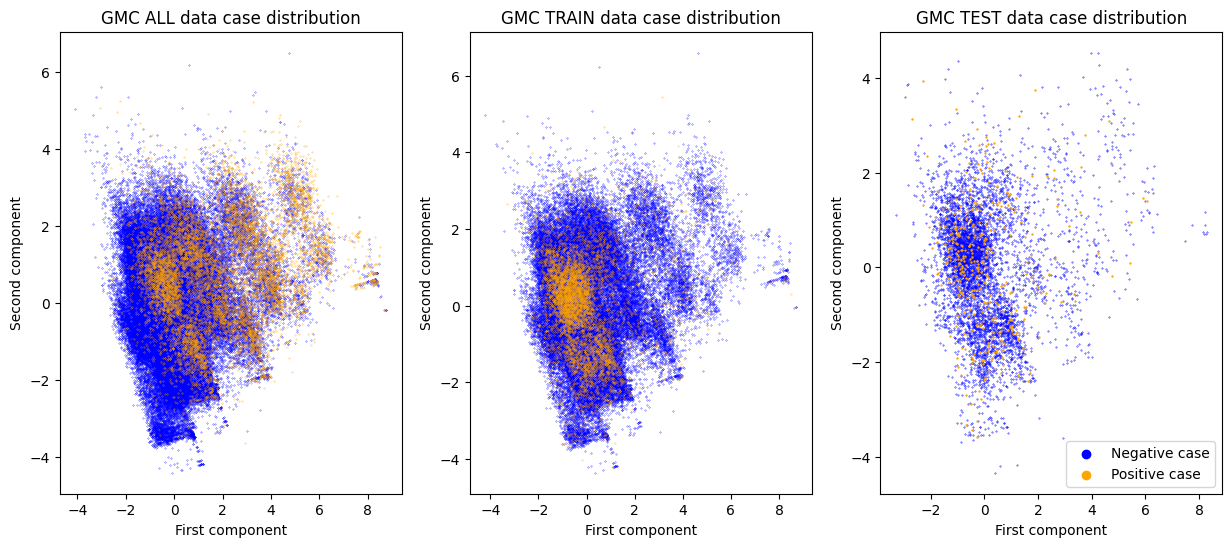

In [47]:
figure, axis = plt.subplots(1, 3, figsize=(15, 6))
pca = PCA(n_components=2)
#all data 
data = pd.DataFrame(pca.fit_transform(X))
data[3] = y
neg = data[data[3]==0].drop(columns=3)
pos = data[data[3]==1].drop(columns=3)
axis[0].scatter(neg[0], neg[1], color='blue', s=0.05)
axis[0].scatter(pos[0], pos[1],  color='orange', s=0.05)
axis[0].scatter([], [], color='blue', label='Negative case')
axis[0].scatter([], [], color='orange', label='Positive case')
axis[0].set_xlabel('First component')
axis[0].set_ylabel('Second component')
axis[0].set_title('GMC ALL data case distribution')

#train data
data = pd.DataFrame(pca.fit_transform(X_train))
data[3] = y_train
neg = data[data[3]==0].drop(columns=3)
pos = data[data[3]==1].drop(columns=3)
axis[1].scatter(neg[0], neg[1], color='blue', s=0.05)
axis[1].scatter(pos[0], pos[1],  color='orange', s=0.05)
axis[1].scatter([], [], color='blue', label='Negative case')
axis[1].scatter([], [], color='orange', label='Positive case')
axis[1].set_xlabel('First component')
axis[1].set_ylabel('Second component')
axis[1].set_title('GMC TRAIN data case distribution')

data = pd.DataFrame(pca.transform(X_test))
data[3] = y_test
neg = data[data[3]==0].drop(columns=3)
pos = data[data[3]==1].drop(columns=3)
axis[2].scatter(neg[0], neg[1], color='blue', s=0.1)
axis[2].scatter(pos[0], pos[1],  color='orange', s=0.5)
axis[2].scatter([], [], color='blue', label='Negative case')
axis[2].scatter([], [], color='orange', label='Positive case')
axis[2].set_xlabel('First component')
axis[2].set_ylabel('Second component')
axis[2].set_title('GMC TEST data case distribution')
plt.legend()
plt.show()

In [11]:
y = data[3].rename('y')
X = data.drop(columns=3).rename(columns={0:'first component',
                                         1:'second component'})

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
upper = 30000
rescalor_data = rescalor(1, X_train[:upper], X_test, y_train[:upper])
rescalor_data.rescaling()
reg_w_1, lr_w_1, mi_w_1 = rescalor_data.reg_w, rescalor_data.lr_w, rescalor_data.mi_w
orig_train_1, reg_train_1, lr_train_1, mi_train_1 = rescalor_data.get_data()
orig_test_1, reg_test_1, lr_test_1, mi_test_1 = rescalor_data.get_data(test=True)

rescalor_data = rescalor(2, X_train[:upper], X_test, y_train[:upper])
rescalor_data.rescaling()
reg_w_2, lr_w_2, mi_w_2 = rescalor_data.reg_w, rescalor_data.lr_w, rescalor_data.mi_w
orig_train_2, reg_train_2, lr_train_2, mi_train_2 = rescalor_data.get_data()
orig_test_2, reg_test_2, lr_test_2, mi_test_2 = rescalor_data.get_data(test=True)

rescalor_data = rescalor(3, X_train[:upper], X_test, y_train[:upper])
rescalor_data.rescaling()
reg_w_3, lr_w_3, mi_w_3 = rescalor_data.reg_w, rescalor_data.lr_w, rescalor_data.mi_w
orig_train_3, reg_train_3, lr_train_3, mi_train_3 = rescalor_data.get_data()
orig_test_3, reg_test_3, lr_test_3, mi_test_3 = rescalor_data.get_data(test=True)

c:\Users\king0\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
ew_w_1 = np.ones(len(reg_w_1))
weight_1 = [ew_w_1, reg_w_1, lr_w_1, mi_w_1]
ew_w_2 = np.ones(len(reg_w_2))
weight_2 = [ew_w_2, reg_w_2, lr_w_2, mi_w_2]
ew_w_3 = np.ones(len(reg_w_3))
weight_3 = [ew_w_3, reg_w_3, lr_w_3, mi_w_3]


print('origin data')
print(np.round(pd.DataFrame(np.percentile(weight_1, [0, 10, 25, 50, 75, 90, 100], axis=1))\
.rename(columns={0:'EW', 1:'REG', 2:'LR', 3:'MI'}, 
        index={0:'min', 1:'10%', 2:'25%', 3:'median', 4:'75%', 5:'90%', 6:'max'}).T, 2))

print('quadratic data')
print(np.round(pd.DataFrame(np.percentile(weight_2, [0, 10, 25, 50, 75, 90, 100], axis=1))\
.rename(columns={0:'EW', 1:'REG', 2:'LR', 3:'MI'}, 
        index={0:'min', 1:'10%', 2:'25%', 3:'median', 4:'75%', 5:'90%', 6:'max'}).T, 2))

print('cubic data')
print(np.round(pd.DataFrame(np.percentile(weight_3, [0, 10, 25, 50, 75, 90, 100], axis=1))\
.rename(columns={0:'EW', 1:'REG', 2:'LR', 3:'MI'}, 
        index={0:'min', 1:'10%', 2:'25%', 3:'median', 4:'75%', 5:'90%', 6:'max'}).T, 2))

origin data
      min   10%   25%  median   75%   90%   max
EW   1.00  1.00  1.00    1.00  1.00  1.00  1.00
REG  0.03  0.03  0.04    0.05  0.06  0.06  0.07
LR   0.36  0.38  0.43    0.49  0.56  0.60  0.63
MI   0.01  0.02  0.02    0.03  0.04  0.05  0.05
quadratic data
     min   10%   25%  median   75%   90%   max
EW   1.0  1.00  1.00    1.00  1.00  1.00  1.00
REG  0.0  0.00  0.00    0.01  0.03  0.04  0.05
LR  -0.1 -0.09 -0.07   -0.00  0.53  0.82  1.01
MI   0.0  0.01  0.01    0.03  0.04  0.05  0.05
cubic data
      min   10%   25%  median   75%   90%   max
EW   1.00  1.00  1.00    1.00  1.00  1.00  1.00
REG -0.00 -0.00 -0.00    0.00  0.02  0.03  0.05
LR  -0.21 -0.09 -0.02   -0.00  0.03  0.69  1.05
MI   0.00  0.01  0.01    0.03  0.04  0.05  0.05


In [19]:
dataset_train = [orig_train_1, reg_train_1, lr_train_1, mi_train_1, 
                 orig_train_2, reg_train_2, lr_train_2, mi_train_2,
                 orig_train_3, reg_train_3, lr_train_3, mi_train_3]

dataset_test = [orig_test_1, reg_test_1, lr_test_1, mi_test_1,
                orig_test_2, reg_test_2, lr_test_2, mi_test_2,
                orig_test_3, reg_test_3, lr_test_3, mi_test_3] 

ratio_train, ratio_test, entropy_train, entropy_test, auc_train, auc_test = [], [], [], [], [], []  
for train_data, test_data in zip(dataset_train, dataset_test):# <-different rescaled data
    ratio_set_train, entropy_set_train, ratio_set_test,  entropy_set_test, auc_set_train, auc_set_test= [], [], [], [], [], []
    #auc_set_train = [] <- [[lr, xgb](k=2), [lr, xgb](k=3)]
    
    for K in range(1, 10) :
        C = cluster_prediction(train_data, test_data, y_train, y_test, K)
        C.cluster_model()
        ratio_tr = C.default_ratio()
        ratio_te = C.default_ratio(test=True)
        if K > 1 :
            ratio_set_train.append(ratio_tr)
            entropy_set_train.append(C.entropy())
            ratio_set_test.append(ratio_te)
            entropy_set_test.append(C.entropy(test=True))
        if K <= 3:
            auc_set_train.append(C.submodel_auc())
            auc_set_test.append(C.submodel_auc(test=True))

    ratio_train.append(ratio_set_train)            # [[EW_ratio_1], [REG_ratio_1], [LR_ratio_1], [MI_ratio_1], [EW_ratio_2], [REG_ratio_2], [LR_ratio_2], [MI_ratio_2],...]   
                                                   # in [EW_ratio_1] -> [[0.06], [0.02, 0.14], [0.012, 0.07, 0.03], [0.018, 0.019, 0.1, 0.12],...]      
    entropy_train.append(entropy_set_train) 
    ratio_test.append(ratio_set_test)
    entropy_test.append(entropy_set_test)
    auc_train.append(auc_set_train)                
    # [[[EW_K=1_D=1], [EW_K=2_D=1], [EW_K=3_D=1]],
    #  [[REG_K=1_D=1],[REG_K=2_D=1],[REG_K=3_D=1]],
    #  [[LR_K=1]_D=1,[LR_K=2_D=1],[LR_K=3_D=1]], 
    #  [[MI_K=1_D=1],[MI_K=2_D=1],[MI_K=3_D=1]],
    #  [[EW_K=1_D=2], [EW_K=2_D=2], [EW_K=3_D=2]], ...]
    auc_test.append(auc_set_test)
    #auc: 1.指定要哪一種scalored data以及什麼維度 2. 要K為多少的 3.得到[lr, xgb]


ratio_trainp, ratio_testp, entropy_trainp, entropy_testp, auc_trainp, auc_testp = [], [], [], [], [], [] 
for train_data, test_data in zip(dataset_train, dataset_test):
    ratio_set_train, entropy_set_train, ratio_set_test,  entropy_set_test, auc_set_train, auc_set_test= [], [], [], [], [], []    
    for K in range(1, 10) :
        Cp = cluster_prediction(train_data, test_data, y_train, y_test, K)
        Cp.cluster_model(positive=True)
        ratio_tr = Cp.default_ratio()
        ratio_te = Cp.default_ratio(test=True)
        if K > 1 :
            ratio_set_train.append(ratio_tr)
            entropy_set_train.append(Cp.entropy())
            ratio_set_test.append(ratio_te)
            entropy_set_test.append(Cp.entropy(test=True))
        if K <= 3:
            auc_set_train.append(Cp.submodel_auc())
            auc_set_test.append(Cp.submodel_auc(test=True))

    ratio_trainp.append(ratio_set_train)                 
    entropy_trainp.append(entropy_set_train) 
    ratio_testp.append(ratio_set_test)
    entropy_testp.append(entropy_set_test)
    auc_trainp.append(auc_set_train)                
    auc_testp.append(auc_set_test)

KeyboardInterrupt: 

In [118]:
default_rate(defaultrate_data)

In [120]:
entropy_trend(entropytrend_data)

In [121]:
AUC_comparision(AUC_data)